# How important is campaign spending in winning the US Election?

This project will use data modelling to investigate the extent of the predictive power of election spending on the outcomes of the US Elections in 2016, 2012, and 2008. 

For a full description of the analysis question and the findings from the analysis below, see the full report associated with this workbook.

## 1. Set-up

### 1.1 Import Libraries

Libraries required by the workbook.

In [406]:
#Libraries to be utalised
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import chardet
import geopandas as gpd #conda install -c conda-forge geopandas
% matplotlib inline

from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

### 1.2 Functions

Some functions utilized in the analysis below.

In [407]:
#Function to support importing data/finding correct incoding
def find_encoding(fname):
    """
    This function supports the read_csv function in python by returning the file encoding ahead of import.
    Function format provided by the following response on StackExchange:
    https://stackoverflow.com/questions/3323770/character-detection-in-a-text-file-in-python-using-the-universal-encoding-detect
    

    Parameters
    ----------
    fname: csv/text file name or path
        The file you require the encoding for

    Returns
    -------
    charenc
        The encoding for the csv file passed in fname

    """
    r_file = open(fname, 'rb').read()
    result = chardet.detect(r_file)
    charenc = result['encoding']
    return charenc

In [408]:
def naive_bayes_model_cv_score(DF, pred_variables, target_variables):
    """
    Builds a Gaussian Distributed Naive Bayes model.
    Returns the cross validation error (k=5)

    Parameters
    ----------
    DF : dataframe
        A pandas dataframe of containing the values for the prediction and target varibale
    pred_variables : array
        a list of the variable names from the dataframe on which to model on
    target_variable : single item array
        the variable name of the variable to be predicted

    Returns
    -------
    mean(cv_score)
        The average cross validation score of the model

    """
    prediction_DF = DF[pred_variables]
    target_values = DF[target_variables]
    gnb = GaussianNB()
    cv_score = cross_val_score(gnb, prediction_DF, target_values.values.ravel(), cv=10)
    
    return cv_score.mean()

In [409]:
def log_reg_model_cv_score(DF, pred_variables, target_variables):
    """
    Builds a Logistic Regression model.
    Returns the cross validation error (k=5)

    Parameters
    ----------
    DF : dataframe
        A pandas dataframe of containing the values for the prediction and target varibale
    pred_variables : array
        a list of the variable names from the dataframe on which to model on
    target_variable : single item array
        the variable name of the variable to be predicted

    Returns
    -------
    mean(cv_score)
        The average cross validation score of the model

    """
    prediction_DF = DF[pred_variables]
    target_values = DF[target_variables]
    logreg = LogisticRegression()
    cv_score = cross_val_score(logreg, prediction_DF, target_values.values.ravel(), cv=10)
    
    return cv_score.mean()


In [410]:
def linear_SVC_model_cv_score(DF, pred_variables, target_variables):
    """
    Builds a Linear Support Vector Classification model.
    Returns the cross validation error (k=5)

    Parameters
    ----------
    DF : dataframe
        A pandas dataframe of containing the values for the prediction and target varibale
    pred_variables : array
        a list of the variable names from the dataframe on which to model on
    target_variable : single item array
        the variable name of the variable to be predicted

    Returns
    -------
    mean(cv_score)
        The average cross validation score of the model

    """
    prediction_DF = DF[pred_variables]
    target_values = DF[target_variables]
    clf = LinearSVC()
    cv_score = cross_val_score(clf, prediction_DF, target_values.values.ravel(), cv=10)
    
    return cv_score.mean()


In [411]:
def detailed_spend_table(disb_df, committee_name, party, list_USStates):
    
    """
    Takes a single yer disbursement table from the FEC, and the name of the campaign committee in question,
    and returns a clean table with a state by state detailed spend breakdown the for candidate.

    Parameters
    ----------
    disb_df : a pandas dataframe
        A disbursement table as downloaded from the FEC.  Should contain only one year, and one candidate.
    committee_name : a string
        The name of the candidate's election committee
    party : a string
        Either 'RP' or 'DC'
    list_USStates : a list
        A list of 51 US State codes.  This list is used to ensure that only actual US states are returned.
        The dataset includes a few of US state codes that do not match offical descriptions.  These are either typos, 
        or they intentionally refer to a non state (eg an International Disbursement).  As they represent only a small number
        of observations, they have been excluded from the analysis.

    Returns
    -------
    df_detailed_spend_by_state
        A clean dataframe of the state by state detailed spend.
    """
    
    #Filtering the dataframe to include on those associate with the committee name specified in the function call
    party_idx = disb_df['committee_name'] == committee_name
    election_spending_year_can_detailed = disb_df[party_idx]
    #Pivoting the dataframe to create a table where each observation represents the total amount disbursed in the state
    election_spending_year_can_detailed = election_spending_year_can_detailed.pivot_table(index=['recipient_state'],
                                            columns=['disbursement_purpose_category'], 
                                            values = 'disbursement_amount', aggfunc=np.sum)
    #Renaming the detailed columns (based on the party specified in the function call)
    if party == 'RP':
        column_names_Detailed_RP = {'ADMINISTRATIVE':'Spend_RP_Admin', 'ADVERTISING': 'Spend_RP_Advert', 
                                 'FUNDRAISING':'Spend_RP_Fund', 'MATERIALS': 'Spend_RP_Materials', 
                                 'OTHER':'Spend_RP_Other', 'REFUNDS': 'Spend_RP_Refunds', 
                                 'TRANSFERS':'Spend_RP_Transfers', 'TRAVEL': 'Spend_RP_Travel',
                                'LOAN-REPAYMENTS':'Spend_RP_Loan'}
        election_spending_year_can_detailed = election_spending_year_can_detailed.rename(columns=column_names_Detailed_RP)
    else:
        column_names_Detailed_DC = {'ADMINISTRATIVE':'Spend_DC_Admin', 'ADVERTISING': 'Spend_DC_Advert', 
                                 'CONTRIBUTIONS':'Spend_DC_Cont', 
                                 'FUNDRAISING':'Spend_DC_Fund', 'MATERIALS': 'Spend_DC_Materials', 
                                 'OTHER':'Spend_DC_Other', 'REFUNDS': 'Spend_DC_Refunds', 
                                 'TRANSFERS':'Spend_DC_Transfers', 'TRAVEL': 'Spend_DC_Travel'}
        election_spending_year_can_detailed = election_spending_year_can_detailed.rename(columns=column_names_Detailed_DC)
        election_spending_year_can_detailed = election_spending_year_can_detailed[election_spending_year_can_detailed.index.isin(list_USStates)]
   
    #Where a disbursement purpose category has no entries, the cell appears as NaN.  Change this to 0
    election_spending_year_can_detailed = election_spending_year_can_detailed.fillna(0)
    ##Cleaning up the data so that it only contains actual states
    election_spending_year_can_detailed = election_spending_year_can_detailed[election_spending_year_can_detailed.index.isin(list_USStates)]

    
    return election_spending_year_can_detailed

In [412]:
def df_normalizer(DF):
    """
    This function takes a dataframe of numerical values only (excluding the index); and returns a normalized version.
    
    Parameters
    ----------
    DF: a pandas dataframe
        A dataframe containing only numerical values

    Returns
    -------
    df_normalized: a pandas dataframe
        Returns a dataframe with the same shape and index as DF, with normalized values.
        
    """
    min_max_scaler = preprocessing.MinMaxScaler()
    df_normalized = pd.DataFrame(index=DF.index)
    for column in DF.columns:
        temp = DF[[column]].values.astype(float)
        temp_scaled = min_max_scaler.fit_transform(temp)
        df_normalized[column] = temp_scaled
    return df_normalized

### 1.3 Importing Data

#### 1.3.1 FEC Datasets

Data on election campaign spending has been downloaded from the US Federal Election Commission Website:
https://www.fec.gov/data/disbursements/ for the elections in 2016, 2012 and 2008. 

The data was extracted for the campaign disbursements for the period of 1 December in the year prior to the 30th November in the year of the election (a 12 month period).  Only disbursements related to the Democratic and Republican Nominees were captured.  

In [413]:
# Datasets extracted and downloaded from FEC
Disb_2016 = pd.read_csv('2016_FEC_Disbursements.csv', low_memory=False)
print(Disb_2016.head(5))
Disb_2012 = pd.read_csv('2012_FEC_Disbursements.csv', low_memory=False)
print(Disb_2012.head(5))
Disb_2008 = pd.read_csv('2008_FEC_Disbursements.csv', low_memory=False)
print(Disb_2008.head(5))
print(Disb_2016.shape)

  committee_id                       committee_name  report_year report_type  \
0    C00575795                  HILLARY FOR AMERICA         2016         M10   
1    C00575795                  HILLARY FOR AMERICA         2016         12G   
2    C00575795                  HILLARY FOR AMERICA         2016         12G   
3    C00580100  DONALD J. TRUMP FOR PRESIDENT, INC.         2016          M8   
4    C00580100  DONALD J. TRUMP FOR PRESIDENT, INC.         2016          M8   

         image_number line_number transaction_id  file_number entity_type  \
0  201701099041200439         28A        D280853      1137625         IND   
1  201701099041348446          23        D314938      1137788         ORG   
2  201701099041347356          23        D315423      1137788         ORG   
3  201811199133793514          23   SB23.1615102      1291697         ORG   
4  201811199133793514          23   SB23.1615103      1291697         ORG   

  entity_type_desc   ...   schedule_type               s

#### 1.3.2. NY Times election result tables

These results were extracted from the NY Times website reports on election outcomes; specifically 
 - https://www.nytimes.com/elections/2016/results/president
 - https://www.nytimes.com/elections/2012/results/president/big-board.html
 - https://www.nytimes.com/elections/2008/results/president/votes.html

In [414]:
my_encoding = find_encoding('US Election Outcomes.csv')
election_results = pd.read_csv('US Election Outcomes.csv', encoding = my_encoding)
del election_results['Abbreviation']
election_results = election_results.rename(columns={'year':'Year'})

print(election_results.head(5))


  us_state_code us_state_name  num_ec_votes  Year  outcomes_DC  outcomes_RP
0            AL       Alabama             9  2016         0.34         0.62
1            AK        Alaska             3  2016         0.37         0.51
2            AZ       Arizona            11  2016         0.45         0.48
3            AR      Arkansas             6  2016         0.34         0.61
4            CA    California            55  2016         0.62         0.32


In [415]:
#This variable sets a list of 51 US State Codes and US State names, used for data wrangling below.
state_code_name = election_results.iloc[:,0:2]

#### 1.3.3 Race Data from 2010 US Census

This dataset was accessed from https://www.census.gov/data/tables/2017/demo/popest/state-detail.html; Sex, Race, and Hispanic Origin; which provides state-based statistics for the number of people within each state that identify as a one of a subset of races.  The data is from the 2010 census.

In [416]:
# Determine the appropriate encoding
my_encoding = find_encoding('Census2010RaceData.csv')
#Load the dataset
census_2010 = pd.read_csv('Census2010RaceData.csv', encoding = my_encoding)
print(census_2010.head())

  us_state_code       state  Census_2010_Total_Pop  Census_2010_White_Pop  \
0            AL     Alabama              4779736.0              3362877.0   
1            AK      Alaska               710231.0               483873.0   
2            AZ     Arizona              6392017.0              5418483.0   
3            AR    Arkansas              2915918.0              2342403.0   
4            CA  California             37253956.0             27636403.0   

   Census_2010_BlackorAA_Pop  Census_2010_AmIndian_and_NatAlaskan  \
0                  1259224.0                              32903.0   
1                    24441.0                             106268.0   
2                   280905.0                             335278.0   
3                   454021.0                              26134.0   
4                  2486549.0                             622107.0   

   Census_2010_Asian  Census_2010_NatHawaiian_OthPacifIsl  \
0            55240.0                               5208.0   


#### 1.3.4 Age Data from 2010 US Census

This dataset was accessed from https://www.census.gov/data/tables/2017/demo/popest/state-detail.html; Single Year of Age and Sex Population Estimates

This dataset requires some wrangling for the required purposes of comparing the age of populations across US states.
It contains an observation for each singular age (0-98, and 999 representing 99 and older), sex, and state in the US; with an estimate for how this might have changed in the years since the 2010 census.

The intention is to produce a variable that can be associated with each state that represents the age groups of that state.

In [417]:
#Determine file encoding
my_encoding = find_encoding('sc-est2017-agesex-civ.csv')
#Import file
census_age = pd.read_csv('sc-est2017-agesex-civ.csv', encoding = my_encoding)
print(census_age.head())

   SUMLEV  REGION  DIVISION  STATE           NAME  SEX  AGE  ESTBASE2010_CIV  \
0      10       0         0      0  United States    0    0          3944160   
1      10       0         0      0  United States    0    1          3978090   
2      10       0         0      0  United States    0    2          4096939   
3      10       0         0      0  United States    0    3          4119051   
4      10       0         0      0  United States    0    4          4063186   

   POPEST2010_CIV  POPEST2011_CIV  POPEST2012_CIV  POPEST2013_CIV  \
0         3951454         3962971         3926486         3931208   
1         3957695         3966056         3977264         3942441   
2         4090616         3970491         3978648         3991295   
3         4111682         4101643         3981321         3990699   
4         4077326         4121485         4111444         3992298   

   POPEST2014_CIV  POPEST2015_CIV  POPEST2016_CIV  POPEST2017_CIV  
0         3954725         3984294   

#### 1.3.5 US State Shape File for Visulization

File from: https://www.arcgis.com/home/item.html?id=f7f805eb65eb4ab787a0a3e1116ca7e5

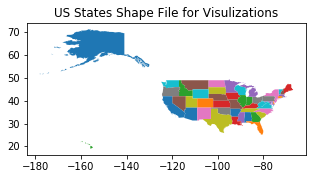

In [418]:
geo_df = gpd.read_file('states.shp')
f, ax = plt.subplots(1, 1, figsize=(5, 4))
geo_df.plot(column='STATE_NAME', ax=ax)
plt.title('US States Shape File for Visulizations')
plt.show()

## 2. Data Wrangling: Creating Summary State Spend Tables and linking these to Election Results


### 2.1 Creating Summarized State Spend Data frames
The disbursements loaded above contain the detail of each disbursement made in the course of the election.  In order to understand the impact of spending on the outcomes of the election, I have transformed the three datasets above into a table showing the spend by election year, state and candidates party.

In [419]:
# ---------- 2016 Tables
#2016 - Pivoting tables to get total spend by state and party candidate for each election
election_spending_2016_summary = Disb_2016.pivot_table(index=['recipient_state'], columns=['committee_name'], 
                                               values = 'disbursement_amount', aggfunc=np.sum)
election_spending_2016_summary.insert(0, 'Year', '2016')
#2016 - Renaming columns
column_names_2016 = {'Year':'Year', 'DONALD J. TRUMP FOR PRESIDENT, INC.': 'Spend_Total_RP', 
                'HILLARY FOR AMERICA':'Spend_Total_DC'}
election_spending_2016_summary = election_spending_2016_summary.rename(columns=column_names_2016)

# ---------- 2012 Tables
#2012 - Pivoting tables to get total spend by state and party candidate for each election
election_spending_2012_summary = Disb_2012.pivot_table(index=['recipient_state'], columns=['committee_name'], 
                                               values = 'disbursement_amount', aggfunc=np.sum)
election_spending_2012_summary.insert(0, 'Year', '2012')
#2012 - Renaming columns
column_names_2012 = {'Year':'Year', 'OBAMA FOR AMERICA': 'Spend_Total_DC', 
                'ROMNEY FOR PRESIDENT INC.':'Spend_Total_RP'}
election_spending_2012_summary = election_spending_2012_summary.rename(columns=column_names_2012)

# ---------- 2008 Tables
#2008 - Pivoting tables to get total spend by state and party candidate for each election
election_spending_2008_summary = Disb_2008.pivot_table(index=['recipient_state'], columns=['committee_name'], 
                                               values = 'disbursement_amount', aggfunc=np.sum)
election_spending_2008_summary.insert(0, 'Year', '2008')

#In 2008, spending from the Republican Party appeared to be split across two campaigns; 'JOHN MCCAIN 2008 INC.' and 
#'MCCAIN-PALIN 2008 INC'.  I've combined these spends here, and deleted the inital columns
election_spending_2008_summary['Spend_Total_RP'] =(election_spending_2008_summary['JOHN MCCAIN 2008 INC.'] + 
                                                   election_spending_2008_summary['MCCAIN-PALIN 2008 INC'])
del election_spending_2008_summary['JOHN MCCAIN 2008 INC.'] 
del election_spending_2008_summary['MCCAIN-PALIN 2008 INC']

#2008 - Renaming columns
column_names_2008 = {'Year':'Year', 'OBAMA FOR AMERICA': 'Spend_Total_DC', 
                     'Spend_Total_RP':'Spend_Total_RP'}
election_spending_2008_summary = election_spending_2008_summary.rename(columns=column_names_2008)


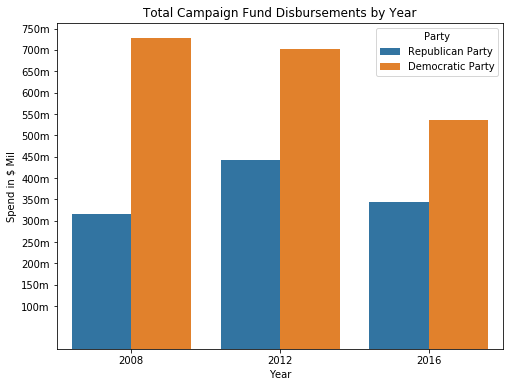

In [420]:
#Visulizing Spending by year and party
#Data needs to be re-wrangled to ensure that spend is in one column
cand_sum_2016 = pd.DataFrame(Disb_2016.groupby(['committee_name']).sum())
cand_sum_2016['Year'] = '2016'
cand_sum_2012 = pd.DataFrame(Disb_2012.groupby(['committee_name']).sum())
cand_sum_2012['Year'] = '2012'
cand_sum_2008 = pd.DataFrame(Disb_2008.groupby(['committee_name']).sum())
cand_sum_2008['Year'] = '2008'

#Joining the two Repulican campaign spends in 2008
temp1 = cand_sum_2008.loc['MCCAIN-PALIN 2008 INC', 'disbursement_amount']
temp2 = cand_sum_2008.loc['JOHN MCCAIN 2008 INC.', 'disbursement_amount']
cand_sum_2008.loc['MCCAIN-PALIN 2008 INC', 'disbursement_amount'] = temp1 + temp2
cand_sum_2008 = cand_sum_2008.drop(['JOHN MCCAIN 2008 INC.'])

total_spend = pd.concat([cand_sum_2008, cand_sum_2012, cand_sum_2016])

Dem_Candidates = {'HILLARY FOR AMERICA', 'OBAMA FOR AMERICA','OBAMA FOR AMERICA'}
Rep_Candidates = {'DONALD J. TRUMP FOR PRESIDENT, INC.', 'ROMNEY FOR PRESIDENT INC.', 'MCCAIN-PALIN 2008 INC' }
total_spend['Party'] = 0
total_spend.loc[Rep_Candidates, 'Party'] = 'Republican Party'
total_spend.loc[Dem_Candidates, 'Party'] = 'Democratic Party'

total_spend['Spend in $ Mil'] = total_spend['disbursement_amount']/1000000

f, ax = plt.subplots(1, 1, figsize=(8, 6))
g = sns.barplot(x='Year', y="Spend in $ Mil", hue="Party", data=total_spend, ax=ax)
plt.title('Total Campaign Fund Disbursements by Year')
plt.yticks([100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750],
           ['100m', '150m', '200m', '250m', '300m', '350m', '400m', '450m', '500m', '550m', '600m',
          '650m','700m', '750m' ])
plt.show()

#### 2.1.1.	Data Derivation: Adding Ratios of spend
The tables above currently show the total amount spent in each state by each parties' candidates in the year leading up to the election.  In order to understand how these spends may have impacted the outcome of the election, I have added two additional two pieces of information: 

- how much of the candidate's budget was spent in each state? 
- how much of the total funds spent in that state was spent by each candidate? 

These two ratios provide information about the comparative spend across the election campaigns, and effectively normalize the spend variable for modelling. 

In [421]:
# ---------- 2016 Tables
#Capturing total spending in the campaign in temporary variables
election_spending_2016_summary['State_Tot_Spend'] = election_spending_2016_summary['Spend_Total_DC'] + election_spending_2016_summary['Spend_Total_RP']
RP_Camp_Total_2016 = election_spending_2016_summary['Spend_Total_RP'].sum() 
DC_Camp_Total_2016 = election_spending_2016_summary['Spend_Total_DC'].sum()

#Create new features in dataset
election_spending_2016_summary['DC_%_State'] = election_spending_2016_summary['Spend_Total_DC']/election_spending_2016_summary['State_Tot_Spend']
election_spending_2016_summary['RP_%_State'] = election_spending_2016_summary['Spend_Total_RP'] / election_spending_2016_summary['State_Tot_Spend']
election_spending_2016_summary['DC_%_Camp'] = election_spending_2016_summary['Spend_Total_DC'] / DC_Camp_Total_2016
election_spending_2016_summary['RP_%_Camp'] = election_spending_2016_summary['Spend_Total_RP'] / RP_Camp_Total_2016

# ---------- 2012 Tables
#Capturing total spending in the campaign in temporary variables
election_spending_2012_summary['State_Tot_Spend'] = election_spending_2012_summary['Spend_Total_DC'] + election_spending_2012_summary['Spend_Total_RP']
RP_Camp_Total_2012 = election_spending_2012_summary['Spend_Total_RP'].sum() 
DC_Camp_Total_2012 = election_spending_2012_summary['Spend_Total_DC'].sum()
election_spending_2012_summary['DC_%_State'] = election_spending_2012_summary['Spend_Total_DC']/election_spending_2012_summary['State_Tot_Spend']
election_spending_2012_summary['RP_%_State'] = election_spending_2012_summary['Spend_Total_RP'] / election_spending_2012_summary['State_Tot_Spend']

#Create new features in dataset
election_spending_2012_summary['DC_%_Camp'] = election_spending_2012_summary['Spend_Total_DC'] / DC_Camp_Total_2012
election_spending_2012_summary['RP_%_Camp'] = election_spending_2012_summary['Spend_Total_RP'] / RP_Camp_Total_2012

# ---------- 2008 Tables
#Capturing total spending in the campaign in temporary variables
election_spending_2008_summary['State_Tot_Spend'] = election_spending_2008_summary['Spend_Total_DC'] + election_spending_2008_summary['Spend_Total_RP']
RP_Camp_Total_2008 = election_spending_2008_summary['Spend_Total_RP'].sum() 
DC_Camp_Total_2008 = election_spending_2008_summary['Spend_Total_DC'].sum()

#Create new features in dataset
election_spending_2008_summary['DC_%_State'] = election_spending_2008_summary['Spend_Total_DC']/election_spending_2008_summary['State_Tot_Spend']
election_spending_2008_summary['RP_%_State'] = election_spending_2008_summary['Spend_Total_RP'] / election_spending_2008_summary['State_Tot_Spend']
election_spending_2008_summary['DC_%_Camp'] = election_spending_2008_summary['Spend_Total_DC'] / DC_Camp_Total_2008
election_spending_2008_summary['RP_%_Camp'] = election_spending_2008_summary['Spend_Total_RP'] / RP_Camp_Total_2008


#### 2.1.2 Concatenating Pivot tables of summary spend for 2016, 2012, and 2008 
To date, the spend tables have been separate.  This step joins them into one data frame 

In [422]:
## Vertically concatinating the 2016, 2012, and 2008 the tables above
frames = [election_spending_2016_summary, election_spending_2012_summary, election_spending_2008_summary]
election_spending_summary = pd.concat(frames)

#Reordering the dataframe
election_spending_summary  = election_spending_summary [['Year', 'State_Tot_Spend', 'Spend_Total_DC', 'Spend_Total_RP',
                                                        'DC_%_State', 'RP_%_State', 'DC_%_Camp', 'RP_%_Camp']]
election_spending_summary['us_state_code'] = election_spending_summary.index
print(election_spending_summary.shape)
print(election_spending_summary.head())

(216, 9)
                 Year  State_Tot_Spend  Spend_Total_DC  Spend_Total_RP  \
recipient_state                                                          
AA               2016              NaN         4626.00             NaN   
AE               2016          4352.75         3938.00          414.75   
AK               2016         54006.09        33761.22        20244.87   
AL               2016       2174654.11      1824841.88       349812.23   
AP               2016              NaN         2100.00             NaN   

                 DC_%_State  RP_%_State  DC_%_Camp  RP_%_Camp us_state_code  
recipient_state                                                              
AA                      NaN         NaN   0.000009        NaN            AA  
AE                 0.904715    0.095285   0.000007   0.000001            AE  
AK                 0.625137    0.374863   0.000063   0.000059            AK  
AL                 0.839141    0.160859   0.003410   0.001018            AL  
AP  

#### 2.1.3 Cleaning/Reducing the summary spend tables to contain only data for each State

The dataset includes a few of US state codes that do not match official descriptions.  These are either typos, or they intentionally refer to a non-state (e.g. an International Disbursement).  As they represent only a small number of observations, they have been excluded from the analysis.  This step removes them.

In [423]:
actual_us_states = election_results['us_state_code']
election_spending_summary_clean = election_spending_summary[election_spending_summary['us_state_code'].isin(actual_us_states)]
print(election_spending_summary_clean.shape)
election_spending_summary = election_spending_summary_clean
election_spending_summary = election_spending_summary.reset_index()

(153, 9)


C:\Anaconda3\lib\site-packages\numpy\core\_methods.py:29: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims)
C:\Anaconda3\lib\site-packages\numpy\core\_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)
C:\Anaconda3\lib\site-packages\matplotlib\colors.py:489: RuntimeWarning: invalid value encountered in less
  xma = np.ma.array(X, copy=True)  # Copy here to avoid side effects.


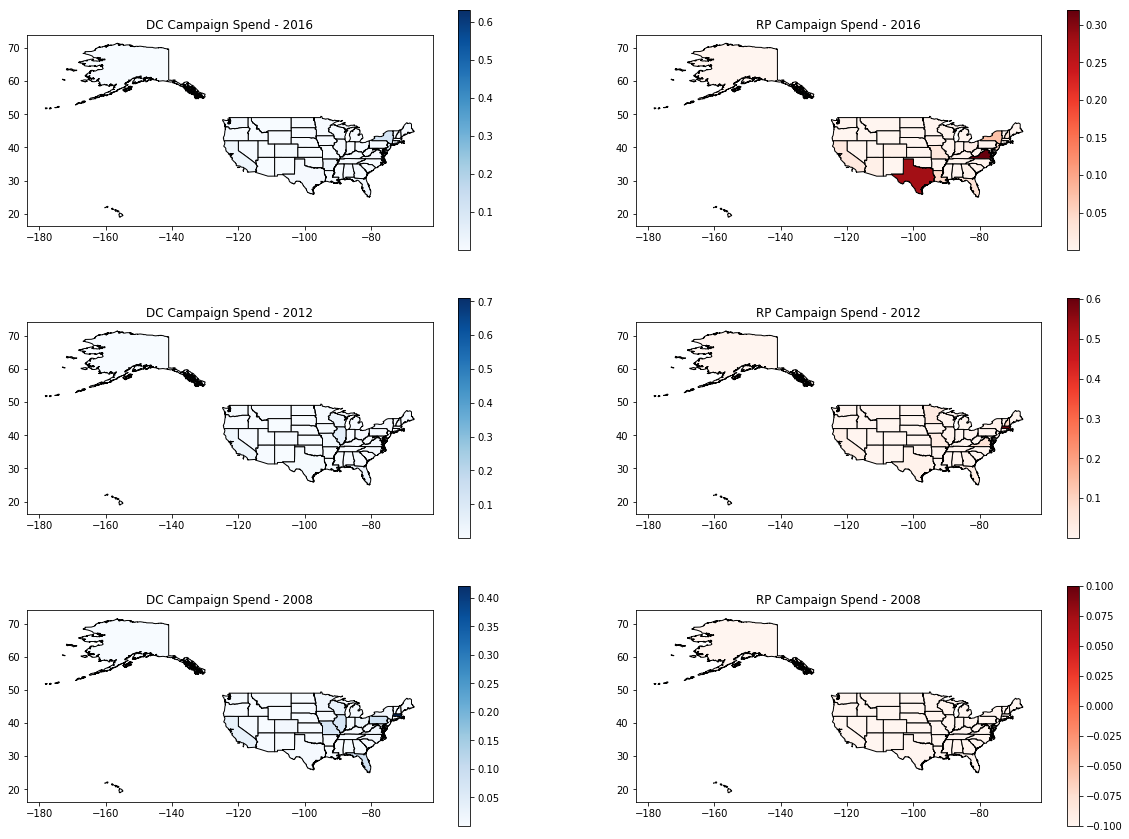

In [424]:
election_spending_2016_summary['STATE_ABBR'] = election_spending_2016_summary.index
election_spending_2016_summary = election_spending_2016_summary[election_spending_2016_summary['STATE_ABBR'].isin(actual_us_states)]
geo_election_spending_2016_summary = geo_df.merge(election_spending_2016_summary, on='STATE_ABBR')

election_spending_2012_summary['STATE_ABBR'] = election_spending_2012_summary.index
election_spending_2012_summary = election_spending_2012_summary[election_spending_2012_summary['STATE_ABBR'].isin(actual_us_states)]
geo_election_spending_2012_summary = geo_df.merge(election_spending_2012_summary, on='STATE_ABBR')


election_spending_2008_summary['STATE_ABBR'] = election_spending_2008_summary.index
election_spending_2008_summary = election_spending_2008_summary[election_spending_2008_summary['STATE_ABBR'].isin(actual_us_states)]
geo_election_spending_2008_summary = geo_df.merge(election_spending_2008_summary, on='STATE_ABBR')

f, ax = plt.subplots(3, 2, figsize=(20, 15))
geo_election_spending_2016_summary.plot(column='DC_%_Camp', cmap='Blues', edgecolor='black', ax=ax[0,0], legend=True)
ax[0,0].set_title('DC Campaign Spend - 2016')

geo_election_spending_2016_summary.plot(column='RP_%_Camp', cmap='Reds', edgecolor='black', ax=ax[0,1], legend=True)
ax[0,1].set_title('RP Campaign Spend - 2016')

geo_election_spending_2012_summary.plot(column='DC_%_Camp', cmap='Blues', edgecolor='black', ax=ax[1,0], legend=True)
ax[1,0].set_title('DC Campaign Spend - 2012')

geo_election_spending_2012_summary.plot(column='RP_%_Camp', cmap='Reds', edgecolor='black', ax=ax[1,1], legend=True)
ax[1,1].set_title('RP Campaign Spend - 2012')

geo_election_spending_2008_summary.plot(column='DC_%_Camp', cmap='Blues', edgecolor='black', ax=ax[2,0], legend=True)
ax[2,0].set_title('DC Campaign Spend - 2008')

geo_election_spending_2008_summary.plot(column='RP_%_Camp', cmap='Reds', edgecolor='black', ax=ax[2,1], legend=True)
ax[2,1].set_title('RP Campaign Spend - 2008')
plt.show()

### 2.2 Joining Election Spending Data with Results Data

In [425]:
elections = pd.concat([election_spending_summary, election_results], axis=1, keys=['Year', 'us_state_code'])
elections.columns = elections.columns.droplevel()
elections = elections.fillna(0) #where there is no spend for a category in the pivot table, pandas assigns Nan.  In the case
#of this project, it is appropriate to change this value to zero, representing zero spend.   
print(elections.head())

  recipient_state  Year  State_Tot_Spend  Spend_Total_DC  Spend_Total_RP  \
0              AK  2016         54006.09        33761.22        20244.87   
1              AL  2016       2174654.11      1824841.88       349812.23   
2              AR  2016      16326491.09     16164333.44       162157.65   
3              AZ  2016       3642257.39       170148.07      3472109.32   
4              CA  2016      22402477.35     14176362.19      8226115.16   

   DC_%_State  RP_%_State  DC_%_Camp  RP_%_Camp us_state_code us_state_code  \
0    0.625137    0.374863   0.000063   0.000059            AK            AL   
1    0.839141    0.160859   0.003410   0.001018            AL            AK   
2    0.990068    0.009932   0.030207   0.000472            AR            AZ   
3    0.046715    0.953285   0.000318   0.010107            AZ            AR   
4    0.632803    0.367197   0.026492   0.023947            CA            CA   

  us_state_name  num_ec_votes  Year  outcomes_DC  outcomes_RP  
0   

### 2.2.1. Data Derivation: Create a binary target variable of the outcome of the election

The models developed for this project are all binary classification models.  These models will return a binary classification outcome for each state (yes or no).  In order to train the model, and determine the accuracy of the supervised learning algorithms, I need to provide a binary target. 

Here I've created the variable 'DC_Victory" which contains True or False depending on whether the Democratic Party was successful in winning the electoral college vote for the state and year of the observation. 

The data provided by the NY Times specifies the percentage of the votes each party won in the state.  An alternative method of modelling the election outcome would be to treat it as a regression problem; where the algorithm predicts the percentage by which a party would win the vote.  The regression estimation is out of the scope of this project; the report includes a short justification of the reasons for this. 

In [426]:
#Create a binary variable of the outcome of the election
elections['DC_Victory'] = elections['outcomes_DC'] > elections['outcomes_RP']
elections['RP_Victory'] = elections['outcomes_DC'] < elections['outcomes_RP']
elections = elections.fillna(0)
print(elections.columns)

#Remove duplicate columns from the dataframe
elections = elections.loc[:, ~elections.columns.duplicated()]
#The code above was taken from https://stackoverflow.com/questions/44400177/removing-multiple-columns-with-the-same-name-except-the-first-one
print(elections.head())

Index(['recipient_state', 'Year', 'State_Tot_Spend', 'Spend_Total_DC',
       'Spend_Total_RP', 'DC_%_State', 'RP_%_State', 'DC_%_Camp', 'RP_%_Camp',
       'us_state_code', 'us_state_code', 'us_state_name', 'num_ec_votes',
       'Year', 'outcomes_DC', 'outcomes_RP', 'DC_Victory', 'RP_Victory'],
      dtype='object')
  recipient_state  Year  State_Tot_Spend  Spend_Total_DC  Spend_Total_RP  \
0              AK  2016         54006.09        33761.22        20244.87   
1              AL  2016       2174654.11      1824841.88       349812.23   
2              AR  2016      16326491.09     16164333.44       162157.65   
3              AZ  2016       3642257.39       170148.07      3472109.32   
4              CA  2016      22402477.35     14176362.19      8226115.16   

   DC_%_State  RP_%_State  DC_%_Camp  RP_%_Camp us_state_code us_state_name  \
0    0.625137    0.374863   0.000063   0.000059            AK       Alabama   
1    0.839141    0.160859   0.003410   0.001018            AL    

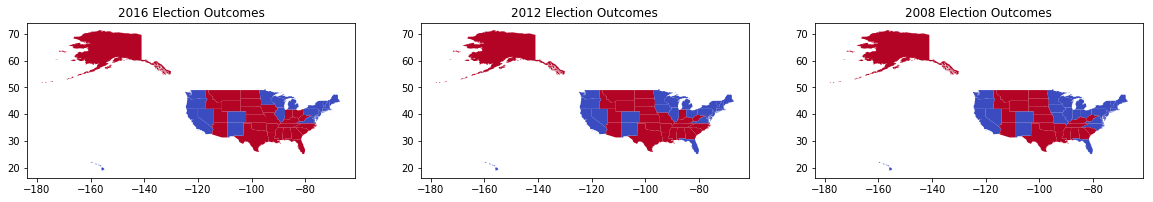

In [427]:
election_results = election_results.rename(columns={"us_state_code":"STATE_ABBR"})
results_geo = geo_df.merge(election_results, on='STATE_ABBR')
results_geo['RP_Victory'] = results_geo['outcomes_DC'] < results_geo['outcomes_RP']

results_geo_2016 = results_geo[results_geo['Year'] == 2016]
results_geo_2012 = results_geo[results_geo['Year'] == 2012]
results_geo_2008 = results_geo[results_geo['Year'] == 2008]

f, ax = plt.subplots(1, 3, figsize=(20, 6))
results_geo_2016.plot(column='RP_Victory', cmap='coolwarm', ax=ax[0])
ax[0].set_title('2016 Election Outcomes')

results_geo_2012.plot(column='RP_Victory', cmap='coolwarm', ax=ax[1])
ax[1].set_title('2012 Election Outcomes')

results_geo_2008.plot(column='RP_Victory', cmap='coolwarm', ax=ax[2])
ax[2].set_title('2008 Election Outcomes')
plt.show()

## 3.	Modelling: Total spend by candidate, state and election:

In this section I have built the first models of the project.  These models are the ones with the least amount of data; simply the summary spend data.  The prediction variables are simply the portion of the total campaign budget the Democrat Candidate and the Republican Candidate spent on each State (DC_%_Camp & RP_%_Camp) , and of the total campaign funds spent in each state, what portion (ratio) was spent by each candidate (DC_%_State & RP_%_State).

As we are aiming to determine the predictive quality, rather than highest performing model, three sperate algorithms will be utilized, and their scores averaged, to reduce the possibility that the performance was due to a quirk of the model or overfitting. 

The three algorithms utilized are: 

#### 1) Naive Bayes (Gaussian Distribution):  
Naïve Bayes uses Bayesian probability theory to classify observations into a target class.  It works well on high dimensional data due to the assumption of independence between each of the variables.  It assumes a distribution for the class conditionality of each of the variables (in the case of the model here, it assumes a normal/gaussian distribution).   

#### 2) Logistic Regression: 
Logistic Regression can be utilized as a classifier when the outcome is binary.  However, logistic regression is susceptible to outliers in the data, and suffers when the variables are highly correlated.  For these reasons, it may not be the best model for the data used in this project. 

#### 3) Linear Support Vector Classification: 
Linear Support Vector Classification algorithms work by plotting the data onto a n-dimensional space.  Based on the target variable provided in the training data, it plots a line that represents the maximum margin between the classes.   

An important first step before modelling is usually to normalize the data to reduce the Euclidean Distance analyzed by each model (unnormalized variables can contain values of radically different size, which makes comparisons based on distance by the models challenging).  However, in this case, as the predictor variables are ratios, and the values at between 0 and 1; further normalization is not required. 

The score reported below are the average cross validation score (based on 10 k fold).  This will be the method by which the models are compared.  Cross validation is particularly useful in this instance, due to the small size of the dataset under analysis (153 observations). 

### 3.1 Cross Validation Score for Naïve Bayes

In [428]:
model_variables =["DC_%_State", "RP_%_State",
    "DC_%_Camp", "RP_%_Camp"]
target_variable = ["DC_Victory"]

print("Naive Bayes model using the following predictors")
print(model_variables)
print("K Fold(10) Validation score when predicting state election outcome is:")
simple_spend_nb_cvscore = naive_bayes_model_cv_score(elections, model_variables, target_variable)
print(simple_spend_nb_cvscore)

Naive Bayes model using the following predictors
['DC_%_State', 'RP_%_State', 'DC_%_Camp', 'RP_%_Camp']
K Fold(10) Validation score when predicting state election outcome is:
0.5563095238095239


### 3.2 Cross Validation Score for Logistic Regression

In [429]:
model_variables =["DC_%_State", "RP_%_State",
    "DC_%_Camp", "RP_%_Camp"]
target_variable = ["DC_Victory"]

print("Logistic Regression model using the following predictors")
print(model_variables)
print("K Fold(10) Validation score when predicting state election outcome is:")
simple_spend_lr_cvscore = log_reg_model_cv_score(elections, model_variables, target_variable)
print(simple_spend_lr_cvscore)


Logistic Regression model using the following predictors
['DC_%_State', 'RP_%_State', 'DC_%_Camp', 'RP_%_Camp']
K Fold(10) Validation score when predicting state election outcome is:
0.5796428571428571


### 3.3 Cross Validation Score for Linear Support Vector Classification

In [431]:
model_variables =["DC_%_State", "RP_%_State",
    "DC_%_Camp", "RP_%_Camp"]
target_variable = ["DC_Victory"]

print("Linear Support Vector Classification using the following predictors")
print(model_variables)
print("K Fold(10) Validation score when predicting state election outcome is:")
simple_spend_LSVC_cvscore = linear_SVC_model_cv_score(elections, model_variables, target_variable)
print(simple_spend_LSVC_cvscore)

Linear Support Vector Classification using the following predictors
['DC_%_State', 'RP_%_State', 'DC_%_Camp', 'RP_%_Camp']
K Fold(10) Validation score when predicting state election outcome is:
0.6260119047619048


## 4. Data Wrangling: Creating Detailed State Spend Tables and Summary and Results Table

The next step is to add further detail to the predictor data frame, in order to see if this improves the model's accuracy (average cross validation score). 

In this step, further details will be added from the disbursement database downloaded from the FEC.  The dataset contained a column, entitled disbursement_purpose_category, which classified each disbursement made by a small number of categories describing the purpose of the funds.  Here, the total amount spent for each purpose category (for each state and candidate) will be added to the dataset. 

The intention here is to see if variation spend categories (eg. greater amount of funds spends on advertising, or potentially travel if this acts as a proxy for time spend engaging directly with voters) plays a role in predicting the outcome of the elections.   

The same three models have been utilized below, with the average cross validation score included for comparison.

### 4.2. Create detailed spend tables for each candidate and election

In [432]:
# ---------- 2016 Tables 
#Creating detailed columns for 2016 Republican Candidate
election_spending_2016_detailed_RP = detailed_spend_table(Disb_2016, 'DONALD J. TRUMP FOR PRESIDENT, INC.', 'RP', actual_us_states)
#Adding blank columns to ensure the tables for each candidate and each year have the same number of columns 
election_spending_2016_detailed_RP['Spend_RP_Cont'] = 0
election_spending_2016_detailed_RP['Spend_RP_Loan'] = 0

#Creating detailed columns for 2016 Demoncrat Candidate
election_spending_2016_detailed_DC = detailed_spend_table(Disb_2016, 'HILLARY FOR AMERICA', 'DC', actual_us_states)
election_spending_2016_detailed_DC['Spend_DC_Loan'] = 0

## 2016 - Joining DC and RP tables above 
election_spending_detailed_2016 = pd.concat([election_spending_2016_detailed_RP, 
                                        election_spending_2016_detailed_DC], axis=1)

# ---------- 2012 Tables
#Creating detailed columns for 2012 Republican Candidate
election_spending_2012_detailed_RP = detailed_spend_table(Disb_2012, 'ROMNEY FOR PRESIDENT INC.', 'RP', actual_us_states)
#Adding blank columns to ensure the tables for each candidate and each year have the same number of columns 
election_spending_2012_detailed_RP['Spend_RP_Cont'] = 0
election_spending_2012_detailed_RP['Spend_RP_Loan'] = 0

#Creating detailed columns for 2016 Demoncrat Candidate2
election_spending_2012_detailed_DC = detailed_spend_table(Disb_2012, 'OBAMA FOR AMERICA', 'DC', actual_us_states)
election_spending_2012_detailed_DC['Spend_DC_Loan'] = 0

## 2012 - Joining DC and RP tables above 
election_spending_detailed_2012 = pd.concat([election_spending_2012_detailed_RP, 
                                        election_spending_2012_detailed_DC], axis=1)

# ---------- 2008 Tables
# The 2008 republican spend data is slightly different that the other years as McCain registered his 
# disbursments across two seperate campaigns.  As a result, the wrangling below was done manually, rather 
# than through the function as above.
#
#Creating detailed columns for 2008 Republican Candidate
election_spending_2008_detailed_RP = Disb_2008[Disb_2008['committee_name'].isin(['JOHN MCCAIN 2008 INC.', 'MCCAIN-PALIN 2008 INC'])]
election_spending_2008_detailed_RP = election_spending_2008_detailed_RP.pivot_table(index=['recipient_state'],
                                            columns=['disbursement_purpose_category'], 
                                            values = 'disbursement_amount', aggfunc=np.sum)
column_names_2008_Detailed_RP = {'ADMINISTRATIVE':'Spend_RP_Admin', 'ADVERTISING': 'Spend_RP_Advert', 
                                 'FUNDRAISING':'Spend_RP_Fund', 'MATERIALS': 'Spend_RP_Materials', 
                                 'OTHER':'Spend_RP_Other', 'REFUNDS': 'Spend_RP_Refunds', 
                                 'TRANSFERS':'Spend_RP_Transfers', 'TRAVEL': 'Spend_RP_Travel',
                                'LOAN-REPAYMENTS':'Spend_RP_Loan'}
election_spending_2008_detailed_RP = election_spending_2008_detailed_RP.rename(columns=column_names_2008_Detailed_RP)
#Where a disbursement purpose category has no entries, the cell appears as NaN.  Change this to 0
election_spending_2008_detailed_RP = election_spending_2008_detailed_RP.fillna(0)
##Cleaning up the data so that it only contains actual states
election_spending_2008_detailed_RP = election_spending_2008_detailed_RP[election_spending_2008_detailed_RP.index.isin(actual_us_states)]


#Adding blank columns to ensure the tables for each candidate and each year have the same number of columns 
election_spending_2008_detailed_RP['Spend_RP_Cont'] = 0
election_spending_2008_detailed_RP['Spend_RP_Travel'] = 0

#Creating detailed columns for 2016 Demoncrat Candidate2
election_spending_2008_detailed_DC = detailed_spend_table(Disb_2008, 'OBAMA FOR AMERICA', 'DC', actual_us_states)
election_spending_2008_detailed_DC['Spend_DC_Loan'] = 0

## 2012 - Joining DC and RP tables above 
election_spending_detailed_2008 = pd.concat([election_spending_2008_detailed_RP, 
                                        election_spending_2008_detailed_DC], axis=1)


#### 4.2.1. Normalizing the Detailed spend tables created above

In order to include these details in the model, we need to normalise the figures.  Below, each spend by purpose category has normalised for each candidate by the overall spend across all states, for that election year.  All figures will be converted to values between 0 and 1. 

In [433]:
election_spending_detailed_2016 = df_normalizer(election_spending_detailed_2016)
election_spending_detailed_2012 = df_normalizer(election_spending_detailed_2012)
election_spending_detailed_2008 = df_normalizer(election_spending_detailed_2008)

### 4.3. Concatenate tables with summary spend and election results

In [434]:
#Firstly, the year and the state code as added as variables to each table.  
election_spending_detailed_2016['Year_d'] = '2016'
election_spending_detailed_2016['us_state_code_d'] = election_spending_detailed_2016.index
election_spending_detailed_2012['Year_d'] = '2012'
election_spending_detailed_2012['us_state_code_d'] = election_spending_detailed_2012.index
election_spending_detailed_2008['Year_d'] = '2008'
election_spending_detailed_2008['us_state_code_d'] = election_spending_detailed_2008.index

In [435]:
# Secondly, the three tables above (one for each election year) are concatenated vertically.
election_spending_detailed_step1 = pd.concat([election_spending_detailed_2016, election_spending_detailed_2012],
                                       ignore_index=True)
election_spending_detailed_step2 = pd.concat([election_spending_detailed_step1, election_spending_detailed_2008],
                                       ignore_index=True)
election_spending_detailed = election_spending_detailed_step2

In [436]:
#Finally, the tables are joined with the election summary spend table from the first set of modelling.
elections_sp_detailed = pd.concat([elections, election_spending_detailed], axis=1, keys=['Year', 'us_state_code'])
elections_sp_detailed.columns = elections_sp_detailed.columns.droplevel()
elections_sp_detailed = elections_sp_detailed.fillna(0) #where there is no spend for a category in the pivot table, pandas assigns Nan.  In the case
#of this project, it is appropriate to change this value to zero, representing zero spend.  

## 5.	Modelling: Summary and detailed purpose category spends by candidate, state and election:

The same three models utilized above are utilized again with the more detailed dataset.  The average cross validation is presented for comparisons.  

### 5.2. Cross Validation Score for Naïve Bayes

In [437]:
model_variables =['Spend_Total_DC',
       'Spend_Total_RP', 'DC_%_State', 'RP_%_State', 'DC_%_Camp', 'RP_%_Camp','Spend_DC_Admin',
       'Spend_DC_Advert', 'Spend_DC_Cont', 'Spend_DC_Fund', 'Spend_DC_Loan',
       'Spend_DC_Materials', 'Spend_DC_Other', 'Spend_DC_Refunds',
       'Spend_DC_Travel', 'Spend_RP_Admin', 'Spend_RP_Advert', 'Spend_RP_Cont',
       'Spend_RP_Fund', 'Spend_RP_Loan', 'Spend_RP_Materials',
       'Spend_RP_Other', 'Spend_RP_Refunds', 'Spend_RP_Transfers',
       'Spend_RP_Travel']
target_variable = ["DC_Victory"]

print("Naive Bayes model using the following predictors")
print(model_variables)
print("K Fold(10) Validation score when predicting state outcome is:")
detail_spend_nb_cvscore = naive_bayes_model_cv_score(elections_sp_detailed, model_variables, target_variable)
print(detail_spend_nb_cvscore)
print("compared with the following score for the simple spend model")
print(simple_spend_nb_cvscore)

Naive Bayes model using the following predictors
['Spend_Total_DC', 'Spend_Total_RP', 'DC_%_State', 'RP_%_State', 'DC_%_Camp', 'RP_%_Camp', 'Spend_DC_Admin', 'Spend_DC_Advert', 'Spend_DC_Cont', 'Spend_DC_Fund', 'Spend_DC_Loan', 'Spend_DC_Materials', 'Spend_DC_Other', 'Spend_DC_Refunds', 'Spend_DC_Travel', 'Spend_RP_Admin', 'Spend_RP_Advert', 'Spend_RP_Cont', 'Spend_RP_Fund', 'Spend_RP_Loan', 'Spend_RP_Materials', 'Spend_RP_Other', 'Spend_RP_Refunds', 'Spend_RP_Transfers', 'Spend_RP_Travel']
K Fold(10) Validation score when predicting state outcome is:
0.5688095238095239
compared with the following score for the simple spend model
0.5563095238095239


### 5.3. Cross Validation Score for Logistic Regression

In [438]:
print("Logistic Regression model using the following predictors")
print(model_variables)
print("K Fold(10) Validation score when predicting state outcome is:")
detail_spend_lr_cvscore = log_reg_model_cv_score(elections_sp_detailed, model_variables, target_variable)
print(detail_spend_lr_cvscore)
print("compared with the following score for the simple spend model")
print(simple_spend_lr_cvscore)

Logistic Regression model using the following predictors
['Spend_Total_DC', 'Spend_Total_RP', 'DC_%_State', 'RP_%_State', 'DC_%_Camp', 'RP_%_Camp', 'Spend_DC_Admin', 'Spend_DC_Advert', 'Spend_DC_Cont', 'Spend_DC_Fund', 'Spend_DC_Loan', 'Spend_DC_Materials', 'Spend_DC_Other', 'Spend_DC_Refunds', 'Spend_DC_Travel', 'Spend_RP_Admin', 'Spend_RP_Advert', 'Spend_RP_Cont', 'Spend_RP_Fund', 'Spend_RP_Loan', 'Spend_RP_Materials', 'Spend_RP_Other', 'Spend_RP_Refunds', 'Spend_RP_Transfers', 'Spend_RP_Travel']
K Fold(10) Validation score when predicting state outcome is:
0.49000000000000005
compared with the following score for the simple spend model
0.5796428571428571


### 5.4. Cross Validation Score for Linear SVC

In [439]:
print("Linear Support Vector Classification using the following predictors")
print(model_variables)
print("K Fold(10) Validation score when predicting state outcome is:")
detail_spend_LSVC_cvscore = linear_SVC_model_cv_score(elections_sp_detailed, model_variables, target_variable)
print(detail_spend_LSVC_cvscore)
print("compared with the following score for the simple spend model")
print(simple_spend_LSVC_cvscore)

Linear Support Vector Classification using the following predictors
['Spend_Total_DC', 'Spend_Total_RP', 'DC_%_State', 'RP_%_State', 'DC_%_Camp', 'RP_%_Camp', 'Spend_DC_Admin', 'Spend_DC_Advert', 'Spend_DC_Cont', 'Spend_DC_Fund', 'Spend_DC_Loan', 'Spend_DC_Materials', 'Spend_DC_Other', 'Spend_DC_Refunds', 'Spend_DC_Travel', 'Spend_RP_Admin', 'Spend_RP_Advert', 'Spend_RP_Cont', 'Spend_RP_Fund', 'Spend_RP_Loan', 'Spend_RP_Materials', 'Spend_RP_Other', 'Spend_RP_Refunds', 'Spend_RP_Transfers', 'Spend_RP_Travel']
K Fold(10) Validation score when predicting state outcome is:
0.4800595238095238
compared with the following score for the simple spend model
0.6260119047619048


## 6.Data Wrangling: Adding age and race population characteristics to the election dataset


### 6.1. Preparing the census race data

The US census is conducted every 10 years, with the last census occurring in 2010.  The data available from the website reports race statistics by state but does not provide an estimate of how these might have changed over the 10 years.  Hense, I am applying the same race breakdown to each state for all three elections, despite the imperfect data.  See full project report for more detail.

In [440]:
#Normalize the figures from the race table from the census
#Sending only the numerical figures for the normalizing function
census_2010_popbyrace_normlz = df_normalizer(census_2010.iloc[:, 2:8]) 

#Reattaching the State code and State to the noramlized figure table
census_2010_popbyrace_normlz = pd.concat([census_2010.iloc[:, 0:2], census_2010_popbyrace_normlz], axis=1)

#Copying the table for each year in the analysis
census_2010_popbyrace_normlz_2016 = census_2010_popbyrace_normlz.copy()
census_2010_popbyrace_normlz_2016['Year'] = '2016'
census_2010_popbyrace_normlz_2012 = census_2010_popbyrace_normlz.copy()
census_2010_popbyrace_normlz_2012['Year'] = '2012'
census_2010_popbyrace_normlz_2008 = census_2010_popbyrace_normlz.copy()
census_2010_popbyrace_normlz_2008['Year'] = '2008'
census_2010_popbyrace_normlz_allyears = pd.concat([census_2010_popbyrace_normlz_2016, 
                                                  census_2010_popbyrace_normlz_2012, 
                                                  census_2010_popbyrace_normlz_2008], ignore_index = True)

In [441]:
#Joining the race data to the election spend data table
elections_sp_detailed_census = pd.concat([elections_sp_detailed, census_2010_popbyrace_normlz_allyears], axis=1, keys=['Year', 'us_state_code'])
elections_sp_detailed_census.columns = elections_sp_detailed_census.columns.droplevel()
elections_sp_detailed_census = elections_sp_detailed_census.fillna(0) #where there is no spend for a category in the pivot table, pandas assigns Nan.  In the case
#of this project, it is appropriate to change this value to zero, representing zero spend.   
print(elections_sp_detailed_census.shape)
print(elections_sp_detailed_census.head(5))

(153, 46)
  recipient_state  Year  State_Tot_Spend  Spend_Total_DC  Spend_Total_RP  \
0              AK  2016         54006.09        33761.22        20244.87   
1              AL  2016       2174654.11      1824841.88       349812.23   
2              AR  2016      16326491.09     16164333.44       162157.65   
3              AZ  2016       3642257.39       170148.07      3472109.32   
4              CA  2016      22402477.35     14176362.19      8226115.16   

   DC_%_State  RP_%_State  DC_%_Camp  RP_%_Camp  us_state_code  ...   \
0    0.625137    0.374863   0.000063   0.000059             AK  ...    
1    0.839141    0.160859   0.003410   0.001018             AL  ...    
2    0.990068    0.009932   0.030207   0.000472             AR  ...    
3    0.046715    0.953285   0.000318   0.010107             AZ  ...    
4    0.632803    0.367197   0.026492   0.023947             CA  ...    

  us_state_code_d  us_state_code       state  Census_2010_Total_Pop  \
0              AK            

### 6.2 Dimensionality reduction for age data 

As discussed above, the data for age requires some wrangling.  The dataset from the FEC contains the number of people in each state for age (e.g. 0, 1, 2.....to 98, and 999 to capture any one above that age).  One approach is to 'bin' the data; i.e., determine age groups and sum the numbers of people within each category, and include this information in the analysis.  A challenge with this method is that the age groups/bins are arbitrary, and too few or too many may skew the analysis.  Another method to reduce high dimensional data is to use a dimensionality reduction method, such as principle component analysis (PCA), to summarize the difference between the observations into a reduced number of variables.  Below, I have attempted this method. 

In [442]:
#Firstly, remove the summary country entry in the table for the whole of the USA
census_age = census_age[census_age.NAME != 'United States']

# Next I've created a table that shows the state, and number of the population by each age
census_age_dm_2008 = pd.pivot_table(census_age, values='ESTBASE2010_CIV', index=['NAME'],
                                         columns=['AGE'], aggfunc=np.sum)
#For the 2008 election data above, I've used the 2010 census data.  This is a 'best guess' based on the limited information 
#avaliable on the US census website.  See the full report for a discussion on this. 
census_age_dm_2012 = pd.pivot_table(census_age, values='POPEST2012_CIV', index=['NAME'],
                                         columns=['AGE'], aggfunc=np.sum)
census_age_dm_2016 = pd.pivot_table(census_age, values='POPEST2016_CIV', index=['NAME'],
                                         columns=['AGE'], aggfunc=np.sum)

In [443]:
#Normalise the data for each age
census_age_dm_2008_norm = df_normalizer(census_age_dm_2008)
census_age_dm_2012_norm = df_normalizer(census_age_dm_2012)
census_age_dm_2016_norm = df_normalizer(census_age_dm_2016)

In [444]:
#Perform the PCA for each year
pca_2008 = PCA()
principalComponents_2008 = pca_2008.fit_transform(census_age_dm_2008_norm)
pca_2012 = PCA()
principalComponents_2012 = pca_2012.fit_transform(census_age_dm_2012_norm)
pca_2016 = PCA()
principalComponents_2016 = pca_2016.fit_transform(census_age_dm_2016_norm)


In [445]:
#Review the variance explained by each PCA Component
exp_2008 = pca_2008.explained_variance_ratio_
exp_2008 = np.round_(exp_2008,2)
print(exp_2008)
exp_2012 = pca_2012.explained_variance_ratio_
exp_2012 = np.round_(exp_2012,2)
print(exp_2012)
exp_2016 = pca_2016.explained_variance_ratio_
exp_2016 = np.round_(exp_2016,2)
print(exp_2016)

[0.98 0.01 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
[0.98 0.01 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
[0.98 0.01 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.  ]


The series above show the (rounded) figures for the percentage of variance explained by each PCA component.  It shows that for each year, the first PCA component explains 98% of the variance.

This means that we can associate this component with the dataset and summarize much of the variation between ages across the US states in a single variable. 

In [446]:
#For each election year, create a dataframe with the first principle from above, associated with the coresponding states.
# ---------- 2016 Tables
census_age_2008 = pd.DataFrame(data = principalComponents_2008[0], columns = ['Age_PCA'] )
census_age_2008['state'] = census_age_dm_2008.index.copy()
census_age_2008['Year'] = 2008 # With an acceptance that this data is really for 2010
# ---------- 2012 Tables
census_age_2012 = pd.DataFrame(data = principalComponents_2012[0], columns = ['Age_PCA'] )
census_age_2012['state'] = census_age_dm_2012.index.copy()
census_age_2012['Year'] = 2012 
# ---------- 2008 Tables
census_age_2016 = pd.DataFrame(data = principalComponents_2016[0], columns = ['Age_PCA'] )
census_age_2016['state'] = census_age_dm_2016.index.copy()
census_age_2016['Year'] = 2016

In [447]:
print(census_age_2008.head(10))
print(census_age_2012.head(10))
print(census_age_2016.head(10))

    Age_PCA                 state  Year
0 -0.314077               Alabama  2008
1  0.029464                Alaska  2008
2  0.033892               Arizona  2008
3  0.012521              Arkansas  2008
4 -0.012204            California  2008
5 -0.024322              Colorado  2008
6  0.009747           Connecticut  2008
7 -0.002790              Delaware  2008
8 -0.012184  District of Columbia  2008
9  0.007871               Florida  2008
    Age_PCA                 state  Year
0 -0.323711               Alabama  2012
1  0.030915                Alaska  2012
2  0.029172               Arizona  2012
3  0.008445              Arkansas  2012
4 -0.015480            California  2012
5 -0.020428              Colorado  2012
6 -0.008095           Connecticut  2012
7  0.000626              Delaware  2012
8 -0.012188  District of Columbia  2012
9  0.006193               Florida  2012
    Age_PCA                 state  Year
0 -0.345656               Alabama  2016
1  0.033038                Alaska  2016


In [448]:
#Join the age tables together
census_age = pd.concat([census_age_2016, census_age_2012, census_age_2008], ignore_index=True)

### 6.3  Adding the race and age data to the election spend dataset

In [449]:
# Join the age table to the elections data set
elections_sp_detailed_census_age = pd.concat([elections_sp_detailed_census, census_age], axis=1, keys=['Year', 'state'])
elections_sp_detailed_census_age.columns = elections_sp_detailed_census_age.columns.droplevel()
print(elections_sp_detailed_census_age['Year'].dtypes)

Year    object
Year    object
Year     int64
dtype: object


## 7. Modelling: Modelling census race and age data with total and detailed purpose category spends by candidate, state and election:

The same three models utilized above are utilized again with the more detailed dataset. The average cross validation is presented for comparisons.

### 7.1. Cross Validation Score for Naïve Bayes

In [450]:
model_variables =['DC_%_State', 'RP_%_State', 'DC_%_Camp', 'RP_%_Camp', 'Year', 'Spend_DC_Admin',
                 'Spend_DC_Advert', 'Spend_DC_Cont', 'Spend_DC_Fund', 'Spend_DC_Loan', 'Spend_DC_Materials',
                 'Spend_DC_Other','Spend_DC_Refunds', 'Spend_DC_Travel', 'Spend_DC_Travel', 
                  'Spend_RP_Admin', 'Spend_RP_Advert', 'Spend_RP_Cont', 'Spend_RP_Fund', 'Spend_RP_Loan',
                 'Spend_RP_Materials', 'Spend_RP_Other', 'Spend_RP_Refunds', 'Spend_RP_Transfers', 'Spend_RP_Travel', 
                 'Census_2010_Total_Pop', 'Census_2010_White_Pop', 'Census_2010_BlackorAA_Pop', 
                  'Census_2010_AmIndian_and_NatAlaskan', 'Census_2010_Asian', 'Census_2010_NatHawaiian_OthPacifIsl',
                 'Age_PCA']
target_variable = ["DC_Victory"]

print("Naive Bayes model using the following predictors")
print(model_variables)
print("K Fold(3) Validation score when predicting state outcome is:")
censusNB = naive_bayes_model_cv_score(elections_sp_detailed_census_age, model_variables, target_variable)
print(censusNB)
print("compared with the following score for the simple spend model")
print(simple_spend_nb_cvscore)
print(" and compared with the following score for the detailed spend model")
print(detail_spend_nb_cvscore)

Naive Bayes model using the following predictors
['DC_%_State', 'RP_%_State', 'DC_%_Camp', 'RP_%_Camp', 'Year', 'Spend_DC_Admin', 'Spend_DC_Advert', 'Spend_DC_Cont', 'Spend_DC_Fund', 'Spend_DC_Loan', 'Spend_DC_Materials', 'Spend_DC_Other', 'Spend_DC_Refunds', 'Spend_DC_Travel', 'Spend_DC_Travel', 'Spend_RP_Admin', 'Spend_RP_Advert', 'Spend_RP_Cont', 'Spend_RP_Fund', 'Spend_RP_Loan', 'Spend_RP_Materials', 'Spend_RP_Other', 'Spend_RP_Refunds', 'Spend_RP_Transfers', 'Spend_RP_Travel', 'Census_2010_Total_Pop', 'Census_2010_White_Pop', 'Census_2010_BlackorAA_Pop', 'Census_2010_AmIndian_and_NatAlaskan', 'Census_2010_Asian', 'Census_2010_NatHawaiian_OthPacifIsl', 'Age_PCA']
K Fold(3) Validation score when predicting state outcome is:
0.5817261904761905
compared with the following score for the simple spend model
0.5563095238095239
 and compared with the following score for the detailed spend model
0.5688095238095239


### 7.2. Cross Validation Score for Logistic Regression

In [451]:
print("Logistic Regression model using the following predictors")
print(model_variables)
print("K Fold(3) Validation score when predicting state outcome is:")
censusLR = log_reg_model_cv_score(elections_sp_detailed_census_age, model_variables, target_variable)
print(censusLR)
print("compared with the following score for the simple spend model")
print(simple_spend_lr_cvscore)
print("and compared with the following score for the detailed spend model")
print(detail_spend_lr_cvscore)

Logistic Regression model using the following predictors
['DC_%_State', 'RP_%_State', 'DC_%_Camp', 'RP_%_Camp', 'Year', 'Spend_DC_Admin', 'Spend_DC_Advert', 'Spend_DC_Cont', 'Spend_DC_Fund', 'Spend_DC_Loan', 'Spend_DC_Materials', 'Spend_DC_Other', 'Spend_DC_Refunds', 'Spend_DC_Travel', 'Spend_DC_Travel', 'Spend_RP_Admin', 'Spend_RP_Advert', 'Spend_RP_Cont', 'Spend_RP_Fund', 'Spend_RP_Loan', 'Spend_RP_Materials', 'Spend_RP_Other', 'Spend_RP_Refunds', 'Spend_RP_Transfers', 'Spend_RP_Travel', 'Census_2010_Total_Pop', 'Census_2010_White_Pop', 'Census_2010_BlackorAA_Pop', 'Census_2010_AmIndian_and_NatAlaskan', 'Census_2010_Asian', 'Census_2010_NatHawaiian_OthPacifIsl', 'Age_PCA']
K Fold(3) Validation score when predicting state outcome is:
0.6682142857142856
compared with the following score for the simple spend model
0.5796428571428571
and compared with the following score for the detailed spend model
0.49000000000000005


### 7.3. Cross Validation Score for Linear SVC

In [452]:
print("Linear SVC model using the following predictors")
print(model_variables)
print("K Fold(3) Validation score when predicting state outcome is:")
censusLSVC = linear_SVC_model_cv_score(elections_sp_detailed_census_age, model_variables, target_variable)
print(censusLSVC)
print("compared with the following score for the simple spend model")
print(simple_spend_LSVC_cvscore)
print("and compared with the following score for the detailed spend model")
print(detail_spend_LSVC_cvscore)

Linear SVC model using the following predictors
['DC_%_State', 'RP_%_State', 'DC_%_Camp', 'RP_%_Camp', 'Year', 'Spend_DC_Admin', 'Spend_DC_Advert', 'Spend_DC_Cont', 'Spend_DC_Fund', 'Spend_DC_Loan', 'Spend_DC_Materials', 'Spend_DC_Other', 'Spend_DC_Refunds', 'Spend_DC_Travel', 'Spend_DC_Travel', 'Spend_RP_Admin', 'Spend_RP_Advert', 'Spend_RP_Cont', 'Spend_RP_Fund', 'Spend_RP_Loan', 'Spend_RP_Materials', 'Spend_RP_Other', 'Spend_RP_Refunds', 'Spend_RP_Transfers', 'Spend_RP_Travel', 'Census_2010_Total_Pop', 'Census_2010_White_Pop', 'Census_2010_BlackorAA_Pop', 'Census_2010_AmIndian_and_NatAlaskan', 'Census_2010_Asian', 'Census_2010_NatHawaiian_OthPacifIsl', 'Age_PCA']
K Fold(3) Validation score when predicting state outcome is:
0.4966666666666667
compared with the following score for the simple spend model
0.6260119047619048
and compared with the following score for the detailed spend model
0.4800595238095238


## 8. Prediction Model Outcomes Summary

### 8.1. Table of Results

In [453]:
columns = ["Gaussian Naive Bayes - Cross Validation Score",
           "Logistic Regression - Cross Validation Score", 
           "Linear Scalar Vector Classification - Cross Validation Score"]
rows = ["Model 1: Summary State by State Spend Data",
        "Model 2: Detailed Purpose Category and Summary State by State Data ",
       "Model 3: Census Age and Race Population Characteristics, Detailed Purpose Category and Summary State by State Data "]
data=[[simple_spend_nb_cvscore, detail_spend_nb_cvscore, censusNB],
     [simple_spend_lr_cvscore, detail_spend_lr_cvscore, censusLR],
     [simple_spend_LSVC_cvscore, detail_spend_LSVC_cvscore, censusLSVC]]

ResultsTable = pd.DataFrame(index=rows, columns=columns, data=data)

print(ResultsTable)

                                                    Gaussian Naive Bayes - Cross Validation Score  \
Model 1: Summary State by State Spend Data                                               0.556310   
Model 2: Detailed Purpose Category and Summary ...                                       0.579643   
Model 3: Census Age and Race Population Charact...                                       0.626012   

                                                    Logistic Regression - Cross Validation Score  \
Model 1: Summary State by State Spend Data                                               0.56881   
Model 2: Detailed Purpose Category and Summary ...                                       0.49000   
Model 3: Census Age and Race Population Charact...                                       0.48006   

                                                    Linear Scalar Vector Classification - Cross Validation Score  
Model 1: Summary State by State Spend Data                                     

## 9. Clustering States by campaign spend, and census details

As a final piece of analysis, I will attempt to cluster states using k means partition-based clustering algorithm considering the election campaign spending, age and race variables.  The aim of this is to identify groupings of states with similarities, on which election candidates may be able to tailor similar election strategies. 

Firstly, I will again transform the data.  Currently the information in organized into a table based on state and election year.  The aim is to transform this into a data frame describing attributes of each state in the table.

In [454]:
#Ensure all 'year' columns are of the same format to enable filtering
elections_sp_detailed_census_age['Year'] = elections_sp_detailed_census_age['Year'].astype(int)
state_attr = elections_sp_detailed_census_age.copy()
state_attr = state_attr.T.drop_duplicates().T
state_attr = state_attr.set_index(['recipient_state', 'Year'])

del state_attr['Year_d']
del state_attr['us_state_code']
del state_attr['state']
del state_attr['us_state_name']

state_attr = state_attr.unstack()
state_attr.head()

State_Tot_Spend                           Spend_Total_DC  \
Year                       2008         2012         2016           2008   
recipient_state                                                            
AK                       485819      53729.3      54006.1         175399   
AL                  3.84351e+06       196649  2.17465e+06    2.59272e+06   
AR                            0       199421  1.63265e+07          97047   
AZ                  1.65573e+07    3.241e+06  3.64226e+06    1.68476e+06   
CA                  3.16475e+07  2.86789e+07  2.24025e+07    2.44914e+07   

                                          Spend_Total_RP               \
Year                    2012         2016           2008         2012   
recipient_state                                                         
AK                   39033.3      33761.2         310420      14695.9   
AL                    153780  1.82484e+06    1.25079e+06      42868.8   
AR                    153096  1.61643e+07              0      46324.7   
AZ               2.02494e+06       170148    1.48725e+07  1.21606e+06   
CA                2.0121e+07  1.41764e+07    7.15606e+06  8.55792e+06   

                             DC_%_State     ...      \
Year                    2016       2008     ...       
recipient_state                             ...       
AK                   20244.9   0.361038     ...       
AL                    349812   0.674571     ...       
AR                    162158          0     ...       
AZ               3.47211e+06   0.101753     ...       
CA               8.22612e+06   0.773882     ...       

                Census_2010_AmIndian_and_NatAlaskan Census_2010_Asian  \
Year                                           2016              2008   
recipient_state                                                         
AK                                        0.0493628         0.0100509   
AL                                         0.167732        0.00680107   
AR                                         0.537223         0.0365169   
AZ                                        0.0384415        0.00653386   
CA                                                1                 1   

                                        Census_2010_NatHawaiian_OthPacifIsl  \
Year                   2012        2016                                2008   
recipient_state                                                               
AK                0.0100509   0.0100509                           0.0277674   
AL               0.00680107  0.00680107                           0.0413062   
AR                0.0365169   0.0365169                           0.0879254   
AZ               0.00653386  0.00653386                           0.0359161   
CA                        1           1                                   1   

                                         Age_PCA                          
Year                  2012       2016       2008        2012        2016  
recipient_state                                                           
AK               0.0277674  0.0277674  -0.314077   -0.323711   -0.345656  
AL               0.0413062  0.0413062  0.0294645   0.0309147   0.0330382  
AR               0.0879254  0.0879254  0.0338922    0.029172   0.0202689  
AZ               0.0359161  0.0359161  0.0125212  0.00844451  0.00955365  
CA                       1          1 -0.0122037  -0.0154801   0.0113914  

[5 rows x 111 columns]

In [455]:
#First try kmeans = 2
kmeans_2 = KMeans(n_clusters=2, random_state=0).fit(state_attr)

In [456]:
kmeans = pd.DataFrame(index=state_attr.index)
kmeans['K means = 2'] = kmeans_2.labels_

print(kmeans.head(10))

                 K means = 2
recipient_state             
AK                         0
AL                         0
AR                         0
AZ                         0
CA                         0
CO                         0
CT                         0
DC                         1
DE                         0
FL                         0


K Means with two clusters groups data into two groups; one with District of Columbia (i.e. Washington), and the rest with the remainder of the country.  This suggests perhaps that the clustering is being influenced by the large campaign spends in the capital.

In [457]:
#Creating clusters with greater numbers
kmeans_3 = KMeans(n_clusters=3, random_state=0).fit(state_attr)
kmeans_4 = KMeans(n_clusters=4, random_state=0).fit(state_attr)
kmeans_5 = KMeans(n_clusters=5, random_state=0).fit(state_attr)
kmeans_6 = KMeans(n_clusters=6, random_state=0).fit(state_attr)
kmeans_7 = KMeans(n_clusters=7, random_state=0).fit(state_attr)
kmeans['K means = 3'] = kmeans_3.labels_
kmeans['K means = 4'] = kmeans_4.labels_
kmeans['K means = 5'] = kmeans_5.labels_
kmeans['K means = 6'] = kmeans_6.labels_
kmeans['K means = 7'] = kmeans_7.labels_
print(kmeans.head(10))

                 K means = 2  K means = 3  K means = 4  K means = 5  \
recipient_state                                                       
AK                         0            0            0            0   
AL                         0            0            0            0   
AR                         0            0            0            0   
AZ                         0            0            0            0   
CA                         0            0            3            2   
CO                         0            0            0            0   
CT                         0            0            0            0   
DC                         1            1            1            1   
DE                         0            0            0            0   
FL                         0            0            3            2   

                 K means = 6  K means = 7  
recipient_state                            
AK                         1            0  
AL             

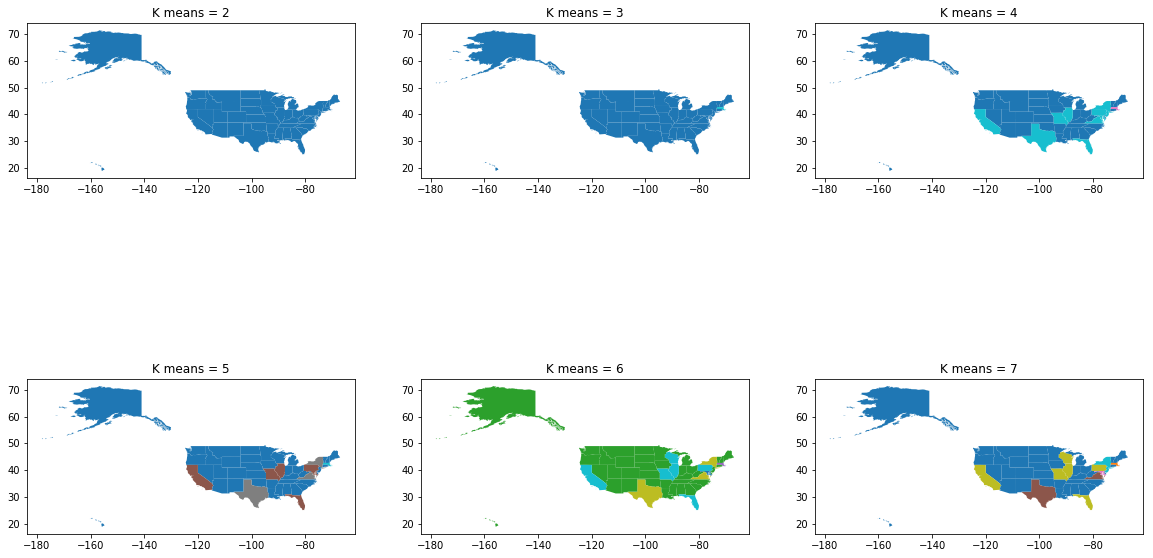

In [458]:
#Visualizing the clusters on maps
cluster_results = kmeans.copy()
cluster_results['STATE_ABBR'] = cluster_results.index.copy()
cluster_geo = geo_df.merge(cluster_results, on='STATE_ABBR')

f, ax = plt.subplots(2, 3, figsize=(20, 12))
cluster_geo.plot(column='K means = 2', cmap='tab10', ax=ax[0,0])
ax[0,0].set_title('K means = 2')

cluster_geo.plot(column='K means = 3', cmap='tab10', ax=ax[0,1])
ax[0,1].set_title('K means = 3')

cluster_geo.plot(column='K means = 4', cmap='tab10', ax=ax[0,2])
ax[0,2].set_title('K means = 4')

cluster_geo.plot(column='K means = 5', cmap='tab10', ax=ax[1,0])
ax[1,0].set_title('K means = 5')

cluster_geo.plot(column='K means = 6', cmap='tab10', ax=ax[1,1])
ax[1,1].set_title('K means = 6')

cluster_geo.plot(column='K means = 7', cmap='tab10', ax=ax[1,2])
ax[1,2].set_title('K means = 7')

plt.show()

After increasing clusters to 7, most states are still grouped in a single cluster.  The challenge is likely to be from the 'State Total Spend', 'Spend Total DC' and 'Spend_Total_RC' columns which are all unnormalized.  Below, I've conducted the analysis again, with these columns removed. 

In [459]:
state_attr2 = elections_sp_detailed_census_age.copy()
state_attr2 = state_attr2.T.drop_duplicates().T
state_attr2 = state_attr2.set_index(['recipient_state', 'Year'])

del state_attr2['Year_d']
del state_attr2['us_state_code']
del state_attr2['state']
del state_attr2['us_state_name']
del state_attr2['State_Tot_Spend']
del state_attr2['Spend_Total_DC']
del state_attr2['Spend_Total_RP']

state_attr2=state_attr2.unstack()

In [460]:
kmeans2 = pd.DataFrame(index=state_attr2.index)
kmeans_2 = KMeans(n_clusters=2, random_state=0).fit(state_attr2)
kmeans_3 = KMeans(n_clusters=3, random_state=0).fit(state_attr2)
kmeans_4 = KMeans(n_clusters=4, random_state=0).fit(state_attr2)
kmeans_5 = KMeans(n_clusters=5, random_state=0).fit(state_attr2)
kmeans_6 = KMeans(n_clusters=6, random_state=0).fit(state_attr2)
kmeans_7 = KMeans(n_clusters=7, random_state=0).fit(state_attr2)
kmeans2['K means = 2'] = kmeans_2.labels_
kmeans2['K means = 3'] = kmeans_3.labels_
kmeans2['K means = 4'] = kmeans_4.labels_
kmeans2['K means = 5'] = kmeans_5.labels_
kmeans2['K means = 6'] = kmeans_6.labels_
kmeans2['K means = 7'] = kmeans_7.labels_


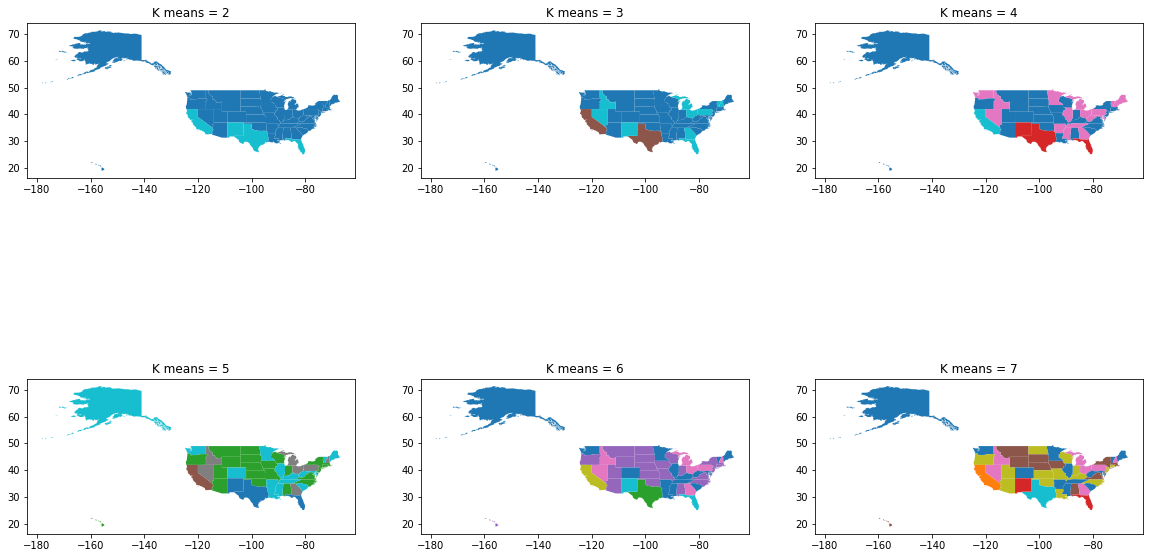

In [461]:
#Visualizing the clusters on maps
cluster_results2 = kmeans2.copy()
cluster_results2['STATE_ABBR'] = cluster_results2.index.copy()
cluster_geo2 = geo_df.merge(cluster_results2, on='STATE_ABBR')

f, ax = plt.subplots(2, 3, figsize=(20, 12))
cluster_geo2.plot(column='K means = 2', cmap='tab10', ax=ax[0,0])
ax[0,0].set_title('K means = 2')

cluster_geo2.plot(column='K means = 3', cmap='tab10', ax=ax[0,1])
ax[0,1].set_title('K means = 3')

cluster_geo2.plot(column='K means = 4', cmap='tab10', ax=ax[0,2])
ax[0,2].set_title('K means = 4')

cluster_geo2.plot(column='K means = 5', cmap='tab10', ax=ax[1,0])
ax[1,0].set_title('K means = 5')

cluster_geo2.plot(column='K means = 6', cmap='tab10', ax=ax[1,1])
ax[1,1].set_title('K means = 6')

cluster_geo2.plot(column='K means = 7', cmap='tab10', ax=ax[1,2])
ax[1,2].set_title('K means = 7')

plt.show()

The clusters above (containing only normalized data) demonstrate a higher level of variety than the initial modelling.  However, given the high dimensionality of the data provided to the clustering algorithm, further work would need to be done to determine the usefulness of this classification. 

 A better approach to determining states where candidates adopt a similar campaign approach may be to focus on a small number of variables that describe a state (perhaps population characteristics from the census), and to investigate how these align with Democratic and Republican Party campaign spending. 

## 10. Clustering on census data only

In [462]:
state_attr_temp = elections_sp_detailed_census_age.copy()
state_attr3 = elections_sp_detailed_census_age.copy()
population_char = {'recipient_state', 'Year', 'Census_2010_Total_Pop', 'Census_2010_White_Pop', 'Census_2010_BlackorAA_Pop',
                   'Census_2010_AmIndian_and_NatAlaskan', 'Census_2010_Asian', 'Census_2010_NatHawaiian_OthPacifIsl', 
                  'Age_PCA'}
is_2016 = state_attr_temp['Year'] == 2016
is_2016 = is_2016.iloc[:, 0]

state_attr3 = state_attr3.loc[is_2016, population_char]
state_attr3 = state_attr3.rename(columns={"Age_PCA": "Age_PCA_2016"})

state_attr3 = state_attr3.set_index('recipient_state')
del state_attr3['Year']
#I've only included one year of the age data to minimize the dimesionality

#I've normalised the age PCA to figures between 0 and 1 so that I can represent 
#the cluster differences in the bar chart below better
age_pca_df = pd.DataFrame(state_attr3['Age_PCA_2016'])
state_attr3['Age_PCA_2016'] = df_normalizer(age_pca_df)

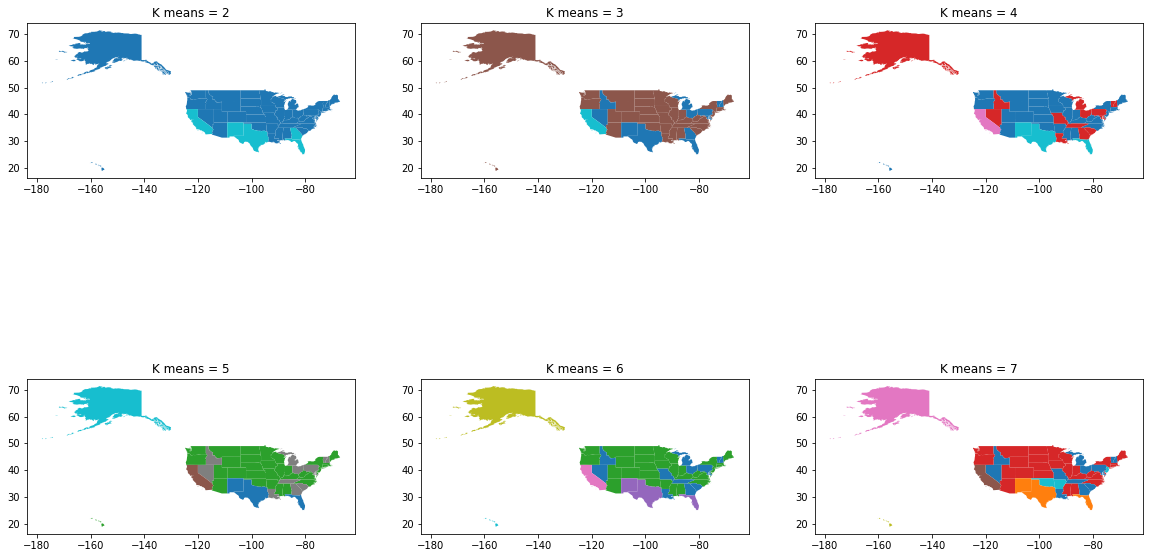

In [463]:
kmeans3 = pd.DataFrame(index=state_attr2.index)
kmeans_2 = KMeans(n_clusters=2, random_state=0).fit(state_attr3)
kmeans_3 = KMeans(n_clusters=3, random_state=0).fit(state_attr3)
kmeans_4 = KMeans(n_clusters=4, random_state=0).fit(state_attr3)
kmeans_5 = KMeans(n_clusters=5, random_state=0).fit(state_attr3)
kmeans_6 = KMeans(n_clusters=6, random_state=0).fit(state_attr3)
kmeans_7 = KMeans(n_clusters=7, random_state=0).fit(state_attr3)
kmeans3['K means = 2'] = kmeans_2.labels_
kmeans3['K means = 3'] = kmeans_3.labels_
kmeans3['K means = 4'] = kmeans_4.labels_
kmeans3['K means = 5'] = kmeans_5.labels_
kmeans3['K means = 6'] = kmeans_6.labels_
kmeans3['K means = 7'] = kmeans_7.labels_
#Visualizing the clusters on maps
cluster_results3 = kmeans3.copy()
cluster_results3['STATE_ABBR'] = cluster_results3.index.copy()
cluster_geo3 = geo_df.merge(cluster_results3, on='STATE_ABBR')

f, ax = plt.subplots(2, 3, figsize=(20, 12))
cluster_geo3.plot(column='K means = 2', cmap='tab10', ax=ax[0,0])
ax[0,0].set_title('K means = 2')

cluster_geo3.plot(column='K means = 3', cmap='tab10', ax=ax[0,1])
ax[0,1].set_title('K means = 3')

cluster_geo3.plot(column='K means = 4', cmap='tab10', ax=ax[0,2])
ax[0,2].set_title('K means = 4')

cluster_geo3.plot(column='K means = 5', cmap='tab10', ax=ax[1,0])
ax[1,0].set_title('K means = 5')

cluster_geo3.plot(column='K means = 6', cmap='tab10', ax=ax[1,1])
ax[1,1].set_title('K means = 6')

cluster_geo3.plot(column='K means = 7', cmap='tab10', ax=ax[1,2])
ax[1,2].set_title('K means = 7')

plt.show()

In [464]:
#Reviewing the clusters - grouping into dataframes for graphing
state_kmeans = pd.concat([state_attr3, kmeans3], axis=1)

k2_1 = state_kmeans[state_kmeans['K means = 2'] == 0]
k2_2 = state_kmeans[state_kmeans['K means = 2'] == 1]

k3_1 = state_kmeans[state_kmeans['K means = 3'] == 0]
k3_2 = state_kmeans[state_kmeans['K means = 3'] == 1]
k3_3 = state_kmeans[state_kmeans['K means = 3'] == 2]

k4_1 = state_kmeans[state_kmeans['K means = 4'] == 0]
k4_2 = state_kmeans[state_kmeans['K means = 4'] == 1]
k4_3 = state_kmeans[state_kmeans['K means = 4'] == 2]
k4_4 = state_kmeans[state_kmeans['K means = 4'] == 3]

k5_1 = state_kmeans[state_kmeans['K means = 5'] == 0]
k5_2 = state_kmeans[state_kmeans['K means = 5'] == 1]
k5_3 = state_kmeans[state_kmeans['K means = 5'] == 2]
k5_4 = state_kmeans[state_kmeans['K means = 5'] == 3]
k5_5 = state_kmeans[state_kmeans['K means = 5'] == 4]

In [465]:
#dropping the cluster labels from the graph
k2_1 = k2_1.drop(columns=['K means = 2', 'K means = 3',
       'K means = 4', 'K means = 5', 'K means = 6', 'K means = 7'])
k2_2 = k2_2.drop(columns=['K means = 2', 'K means = 3',
       'K means = 4', 'K means = 5', 'K means = 6', 'K means = 7'])

k3_1 = k3_1.drop(columns=['K means = 2', 'K means = 3',
       'K means = 4', 'K means = 5', 'K means = 6', 'K means = 7'])
k3_2 = k3_2.drop(columns=['K means = 2', 'K means = 3',
       'K means = 4', 'K means = 5', 'K means = 6', 'K means = 7'])
k3_3 = k3_3.drop(columns=['K means = 2', 'K means = 3',
       'K means = 4', 'K means = 5', 'K means = 6', 'K means = 7'])

k4_1 = k4_1.drop(columns=['K means = 2', 'K means = 3',
       'K means = 4', 'K means = 5', 'K means = 6', 'K means = 7'])
k4_2 = k4_2.drop(columns=['K means = 2', 'K means = 3',
       'K means = 4', 'K means = 5', 'K means = 6', 'K means = 7'])
k4_3 = k4_3.drop(columns=['K means = 2', 'K means = 3',
       'K means = 4', 'K means = 5', 'K means = 6', 'K means = 7'])
k4_4 = k4_4.drop(columns=['K means = 2', 'K means = 3',
       'K means = 4', 'K means = 5', 'K means = 6', 'K means = 7'])

k5_1 = k5_1.drop(columns=['K means = 2', 'K means = 3',
       'K means = 4', 'K means = 5', 'K means = 6', 'K means = 7'])
k5_2 = k5_2.drop(columns=['K means = 2', 'K means = 3',
       'K means = 4', 'K means = 5', 'K means = 6', 'K means = 7'])
k5_3 = k5_3.drop(columns=['K means = 2', 'K means = 3',
       'K means = 4', 'K means = 5', 'K means = 6', 'K means = 7'])
k5_4 = k5_4.drop(columns=['K means = 2', 'K means = 3',
       'K means = 4', 'K means = 5', 'K means = 6', 'K means = 7'])
k5_5 = k5_5.drop(columns=['K means = 2', 'K means = 3',
       'K means = 4', 'K means = 5', 'K means = 6', 'K means = 7'])

In [466]:
#setting the graphing values
k2_1_y = k2_1.mean()
k2_1_x = k2_1.columns.values
k2_2_y = k2_2.mean()
k2_2_x = k2_2.columns.values

k3_1_y = k3_1.mean()
k3_1_x = k3_1.columns.values
k3_2_y = k3_2.mean()
k3_2_x = k3_2.columns.values
k3_3_y = k3_3.mean()
k3_3_x = k3_3.columns.values


k4_1_y = k4_1.mean()
k4_1_x = k4_1.columns.values
k4_2_y = k4_2.mean()
k4_2_x = k4_2.columns.values
k4_3_y = k4_3.mean()
k4_3_x = k4_3.columns.values
k4_4_y = k4_4.mean()
k4_4_x = k4_4.columns.values

k5_1_y = k5_1.mean()
k5_1_x = k5_1.columns.values
k5_2_y = k5_2.mean()
k5_2_x = k5_2.columns.values
k5_3_y = k5_3.mean()
k5_3_x = k5_3.columns.values
k5_4_y = k5_4.mean()
k5_4_x = k5_4.columns.values
k5_5_y = k5_5.mean()
k5_5_x = k5_5.columns.values

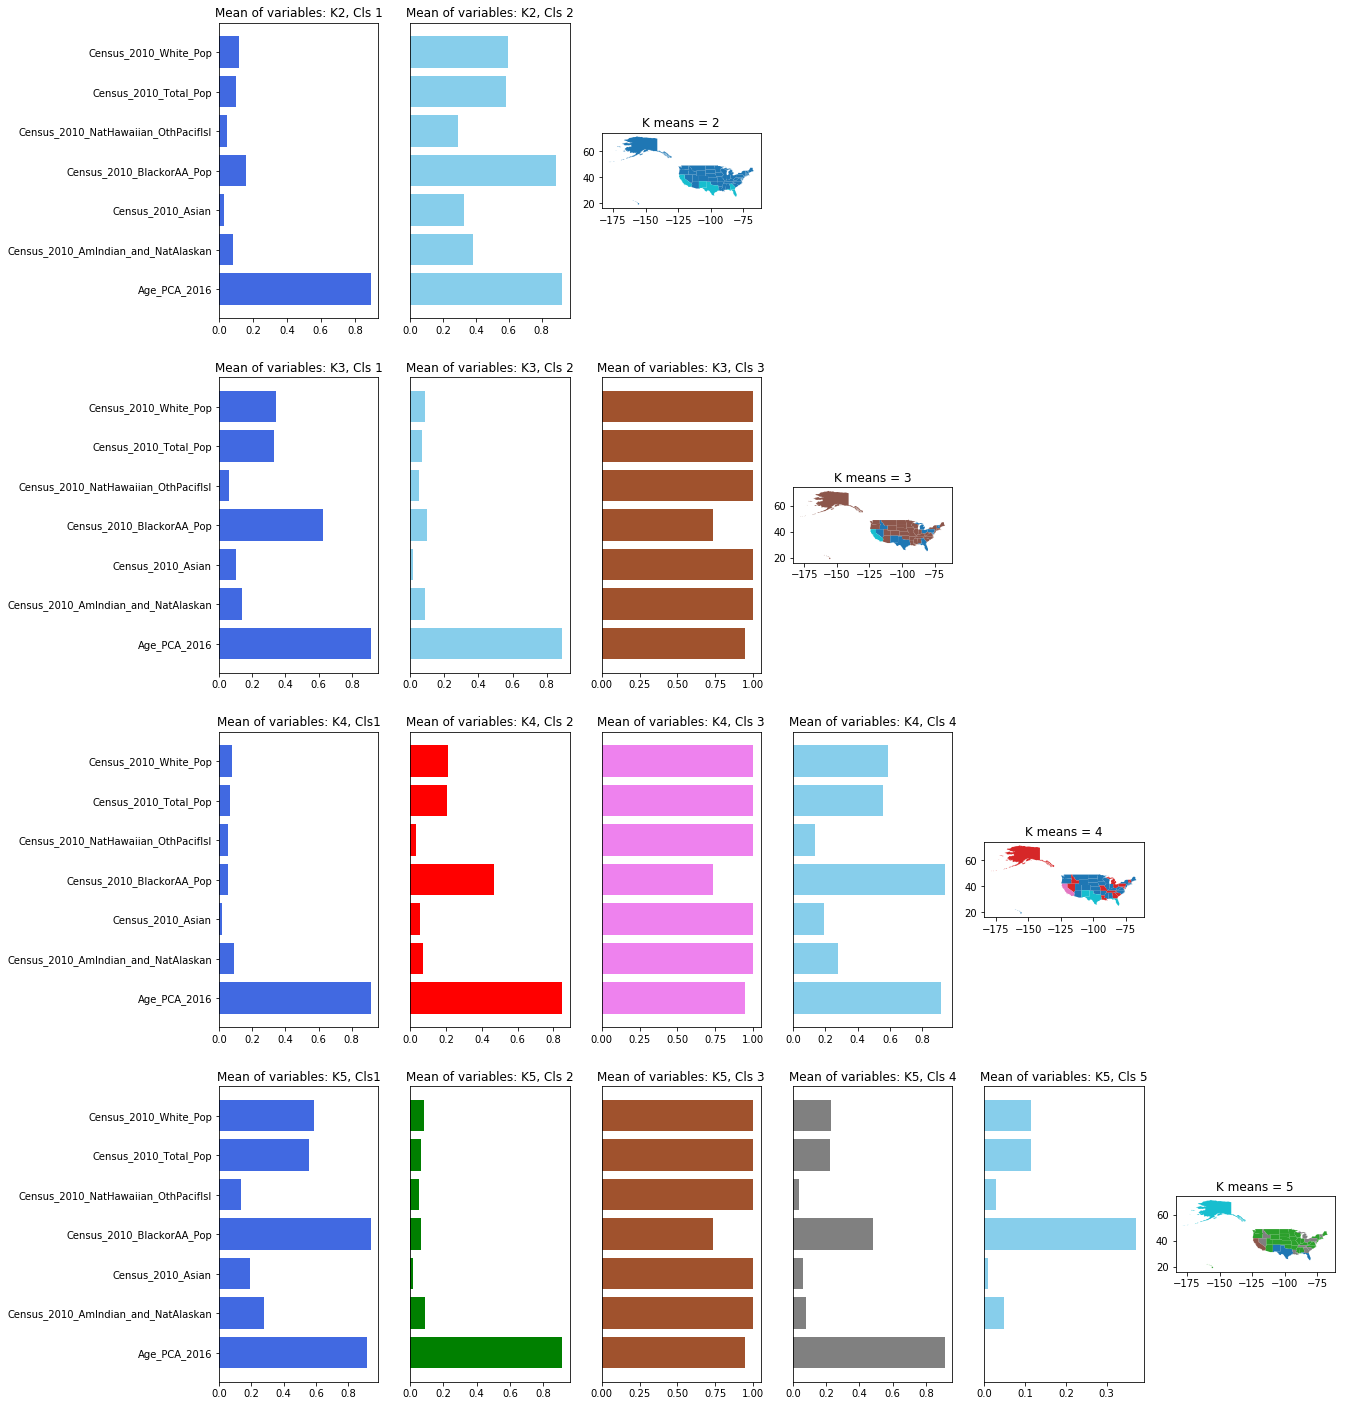

In [467]:
f, ax = plt.subplots(4, 6, figsize=(20, 25))

ax[0,0].barh(k2_1_x, k2_1_y, color='royalblue')
ax[0,0].set_title('Mean of variables: K2, Cls 1') #dark blue royal blue

ax[0,1].barh(k2_2_x, k2_2_y, color='skyblue')
ax[0,1].yaxis.set_visible(False)
ax[0,1].set_title('Mean of variables: K2, Cls 2')#light blue sky blue

cluster_geo3.plot(column='K means = 2', cmap='tab10', ax=ax[0,2])
ax[0,2].set_title('K means = 2')

ax[0,3].xaxis.set_visible(False)
ax[0,3].yaxis.set_visible(False)
ax[0,3].patch.set_visible(False)
ax[0,3].axis('off')

ax[0,4].xaxis.set_visible(False)
ax[0,4].yaxis.set_visible(False)
ax[0,4].patch.set_visible(False)
ax[0,4].axis('off')

ax[0,5].xaxis.set_visible(False)
ax[0,5].yaxis.set_visible(False)
ax[0,5].patch.set_visible(False)
ax[0,5].axis('off')

ax[1,0].barh(k3_1_x, k3_1_y, color='royalblue')
ax[1,0].set_title('Mean of variables: K3, Cls 1') 

ax[1,1].barh(k3_2_x, k3_2_y, color='skyblue')
ax[1,1].yaxis.set_visible(False)
ax[1,1].set_title('Mean of variables: K3, Cls 2')

ax[1,2].barh(k3_3_x, k3_3_y, color='sienna')
ax[1,2].yaxis.set_visible(False)
ax[1,2].set_title('Mean of variables: K3, Cls 3')

cluster_geo3.plot(column='K means = 3', cmap='tab10', ax=ax[1,3])
ax[1,3].set_title('K means = 3')

ax[1,4].xaxis.set_visible(False)
ax[1,4].yaxis.set_visible(False)
ax[1,4].patch.set_visible(False)
ax[1,4].axis('off')

ax[1,5].xaxis.set_visible(False)
ax[1,5].yaxis.set_visible(False)
ax[1,5].patch.set_visible(False)
ax[1,5].axis('off')

ax[2,0].barh(k4_1_x, k4_1_y, color='royalblue')
ax[2,0].set_title('Mean of variables: K4, Cls1') 

ax[2,1].barh(k4_2_x, k4_2_y, color='red')
ax[2,1].yaxis.set_visible(False)
ax[2,1].set_title('Mean of variables: K4, Cls 2')

ax[2,2].barh(k4_3_x, k4_3_y, color='violet')
ax[2,2].yaxis.set_visible(False)
ax[2,2].set_title('Mean of variables: K4, Cls 3')

ax[2,3].barh(k4_4_x, k4_4_y, color='skyblue')
ax[2,3].yaxis.set_visible(False)
ax[2,3].set_title('Mean of variables: K4, Cls 4')

cluster_geo3.plot(column='K means = 4', cmap='tab10', ax=ax[2,4])
ax[2,4].set_title('K means = 4')

ax[2,5].xaxis.set_visible(False)
ax[2,5].yaxis.set_visible(False)
ax[2,5].patch.set_visible(False)
ax[2,5].axis('off') 

ax[3,0].barh(k5_1_x, k5_1_y, color='royalblue')
ax[3,0].set_title('Mean of variables: K5, Cls1') 

ax[3,1].barh(k5_2_x, k5_2_y, color='green')
ax[3,1].yaxis.set_visible(False)
ax[3,1].set_title('Mean of variables: K5, Cls 2')

ax[3,2].barh(k5_3_x, k5_3_y, color='sienna')
ax[3,2].yaxis.set_visible(False)
ax[3,2].set_title('Mean of variables: K5, Cls 3')

ax[3,3].barh(k5_4_x, k5_4_y, color='grey')
ax[3,3].yaxis.set_visible(False)
ax[3,3].set_title('Mean of variables: K5, Cls 4')

ax[3,4].barh(k5_5_x, k5_5_y, color='skyblue')
ax[3,4].yaxis.set_visible(False)
ax[3,4].set_title('Mean of variables: K5, Cls 5')

cluster_geo3.plot(column='K means = 5', cmap='tab10', ax=ax[3,5])
ax[3,5].set_title('K means = 5')

plt.show()

The graphs above show the variation between the clusters for kmeans 2, 3, 4, and 5 clustering. The graphs show quite strong variation at each level of clustering, which suggests that these categorizations of population attributes could be useful for understanding election strategies for a subset of states.